In [74]:
import numpy as np
from scipy import linalg
import torch

import cv2
import sys
import matplotlib.pyplot as plt
sys.path.append("..")
from nc_suite import plot_images, intens_posit_wm, intensity_weight_matrix


seed = 123
dtype = np.float64 # Currently doesn't do anything as random.rand doesn't accept
n = 28
# and possibly generate different sparisities?? As realistically will be somewhat sparse
np.random.seed(seed)


img_baby = cv2.imread("../data/test/3.jpg",0)
img_baby = cv2.resize(img_baby, (28,28))

A = intens_posit_wm(img_baby)

In [75]:
# used to store each of the functions, and allow them to all take the single arg input
from collections import OrderedDict
from functools import partial

# scipy and numpy are used for the eigensolvers
import scipy.linalg as linalg
import scipy.sparse.linalg as sparse

eigs_options = OrderedDict(
    # Numpy (no params only inputs)
    np_eig = np.linalg.eig,
    np_eigh = np.linalg.eigh, # Should be good
    
    # Some parameters for scipy variants
    sp_eig = partial(linalg.eig, check_finite=False), # No extra params

    sp_eigh_base = partial(linalg.eigh), # Should be good (and all variations might improve for the single eigenvector case)
    sp_eigh_cff = partial(linalg.eigh, check_finite=False),
    
    sp_eigh_ev_ss = partial(linalg.eigh, check_finite=False, driver='ev'), # symmetric qr, slow but robust
    # LOBPCG would be nice to test
)

# NOTE: lots of extra info in eigs-test (this is eigs-test2)
        

In [76]:
def objective(y,D,W):
    # obj :         y^T * (D-W) * y / y^T * D * y
    return  ((y.T @ (D-W) @ y) / (y.T @ D @ y)).item()

def eq_const(y,D,ONES):
    # eq const :    y^T * D * 1 = 0
    return (y.T @ D @ ONES).item() # 1x1 so need to get the item out

In [77]:
def cut_cost(cut, W):
    total_weight = 0
    for i in range(len(cut)):
        for j in range(len(cut)): # should be square
            if cut[i] != cut[j]:
                total_weight += W[i][j] # assumes all weights are non-negative
    return total_weight

def ncut_cost(cut, D, W):
    cut = np.array(cut)
    cc = cut_cost(cut, W)

    # D has elements only along the diagonal, one per node, so we can directly
    # index the data attribute with cut.
    # ~ is a bitwise negation operator (flip bits)
    assoc_a = D[cut].sum()
    assoc_b = D[~cut].sum()

    return (cc / assoc_a) + (cc / assoc_b)

def get_ncuts_steps(ev, d, w, num_cuts):
    mcut = np.inf
    mn = ev.min()
    mx = ev.max()

    # If all values in `ev` are equal, it implies that the graph can't be
    # further sub-divided. In this case the bi-partition is the the graph
    # itself and an empty set.
    min_mask = np.zeros_like(ev, dtype=bool)
    if np.allclose(mn, mx):
        return min_mask, mcut

    # Refer Shi & Malik 2001, Section 3.1.3, Page 892
    # Perform evenly spaced n-cuts and determine the optimal one.
    y = np.linspace(mn, mx, num_cuts, endpoint=False)
    y = np.insert(y, np.searchsorted(y, 0), 0) # add 0 to where it needs to be
    x = []
    for t in y:
        mask = ev > t
        cost = ncut_cost(mask, d, w)
        x.append(cost)

    return x,y # costs, partition points

In [78]:
def argmin2(array, both=False):
    # O(n) to find second smallest argmin, instead of sorting O(n^2)
    min1 = np.inf
    min2 = np.inf
    min_idx1 = min_idx2 = i = 0
    n = array.shape[0]
    
    for i in range(n):
        x = array[i]
        if x < min1:
            min2 = min1
            min_idx2 = min_idx1
            min1 = x
            min_idx1 = i
        elif x > min1 and x < min2:
            min2 = x
            min_idx2 = i
    if both:
        return min_idx1, min_idx2
    else:
        return min_idx2

In [79]:

def laplace_expensive(W): # should be more expensive to compute...
    d = W.sum(0)
    sqrt_D_inv = np.diag(np.reciprocal(np.sqrt(d), where=d!=0)) # assumes D is 1 dimensional vector
    D = np.diag(d)
    return sqrt_D_inv @ (D - W) @ sqrt_D_inv

def laplace_cheap(W, shift=0.5): # shift invert (implemented here) should be better...
    d = W.sum(0)
    sqrt_D = np.diag(np.sqrt(d)) # assumes D is 1 dimensional vector
    D = np.diag(d)
    return sqrt_D @ np.linalg.inv(D * (1-shift) - W) @ sqrt_D # no matmul for the D multiplied by constant factor

def post_solve_1(y, num=28):
    return y * num

def post_solve_2(y, D):
    # y = D^0.5 * z
    y = np.sqrt(D) @ y # e.g. if solving generalized need to do this to get y out of z...?
    return y

def non_symm(W):
    # Diagonal Matrix - D
    d = np.sum(W, axis=1)
    D = np.zeros_like(W)
    np.fill_diagonal(D, d)

    A = D - W
    return A

def setdiag(m,d):
    step = len(d) + 1
    m.flat[::step] = d

def symm2(W):
    # L = W + W.T # ensure symmetric
    L = W
    np.fill_diagonal(L,0)
    D = L.sum(0) # symmetric so axis doesn't matter
    isolated_mask = (D == 0)
    D = np.where(isolated_mask, 1, np.sqrt(D))
    L = L/D
    L = L/D[:, np.newaxis]
    L = L * -1
    setdiag(L, 1 - isolated_mask)
    return L

In [80]:
from time import time
import sys
# sys.path.append("../")
# from nc import NormalizedCuts

# node = NormalizedCuts(eps=1e-8, symm_norm_L=True)#, bipart=args.bipart, symm_norm_L=args.symm_norm_L)
# It should be symm norm L, else it isn't NC but min cut
output_cut = []
output_string = []

print('doing so with W = A/max(A)')
W = A/np.max(A) # normalize it for simplicity??
# W = A
d = W.sum(0) # no batch dimension is this version

pre_solvers = [laplace_expensive, symm2]
# post_solvers = [post_solve_1, post_solve_2]

ONES = np.ones_like(d)[..., None]

x_list = []
y_list = []
vals = []
W_tensor = torch.tensor(W[None,...])
D = np.diag(d)
for pre_solver in pre_solvers:
    for name, func in eigs_options.items(): 
        t0 = time()
        L = pre_solver(W)
        w,v = func(L) # The output also includes context (not needed here)
        t = time() - t0
        
        vals.append(w)
        index = argmin2(w)
        y = v[index]
        
        y = np.real(y).squeeze()
        
        # y = np.sqrt(D) @ y
    
        output_cut.append(y.reshape(28,28))
        
        obj = objective(y,D,W)
        eqconst = eq_const(y,D, ONES)
        
        # x,y = get_ncuts_steps(y, D, W, 10) # TODO: make this faster lmao
        # x_list.append(x)
        # y_list.append(y)
        
                
        output_string.append(f'{name}\n{obj:1.3f}\n{eqconst:1.3f}')
        # Check against objetive function, should solve as close to machine precision as possible    
        print(f"{name:20}: {t:5.0f} sec | \tsolution = {obj:1.5f} | \teqconst = {eqconst:1.5f} \t | {pre_solver}\t | v[{index}]")
        
        # TODO: eq const multiplied by eigenvalue

doing so with W = A/max(A)
np_eig              :     1 sec | 	solution = 0.86497 | 	eqconst = -8.21357 	 | <function laplace_expensive at 0x7fa5abe92d30>	 | v[1]
np_eigh             :     0 sec | 	solution = 0.85428 | 	eqconst = -9.32194 	 | <function laplace_expensive at 0x7fa5abe92d30>	 | v[1]
sp_eig              :     1 sec | 	solution = 0.84717 | 	eqconst = -6.98978 	 | <function laplace_expensive at 0x7fa5abe92d30>	 | v[1]
sp_eigh_base        :     0 sec | 	solution = 0.84221 | 	eqconst = -8.09662 	 | <function laplace_expensive at 0x7fa5abe92d30>	 | v[1]
sp_eigh_cff         :     0 sec | 	solution = 0.84221 | 	eqconst = -8.09662 	 | <function laplace_expensive at 0x7fa5abe92d30>	 | v[1]
sp_eigh_ev_ss       :     1 sec | 	solution = 0.84040 | 	eqconst = -12.09781 	 | <function laplace_expensive at 0x7fa5abe92d30>	 | v[1]
np_eig              :     1 sec | 	solution = 0.98668 | 	eqconst = 7.52381 	 | <function symm2 at 0x7fa5abe92550>	 | v[3]
np_eigh             :     0 sec | 	solut

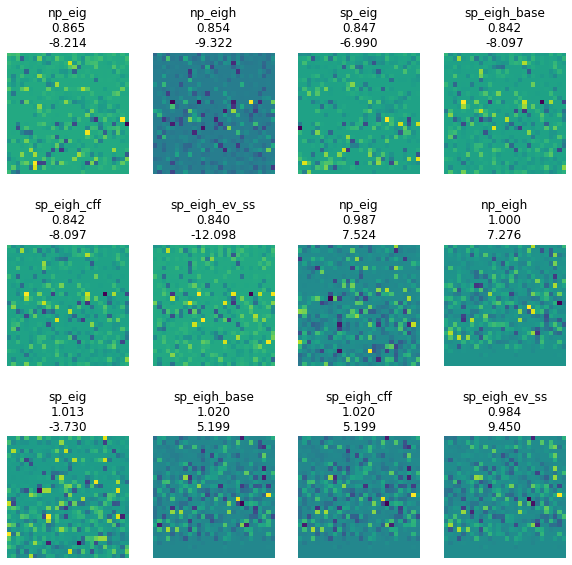

In [81]:
plot_images(output_cut, output_string)

/home/garth/miniconda3/envs/ddn/lib/python3.8/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


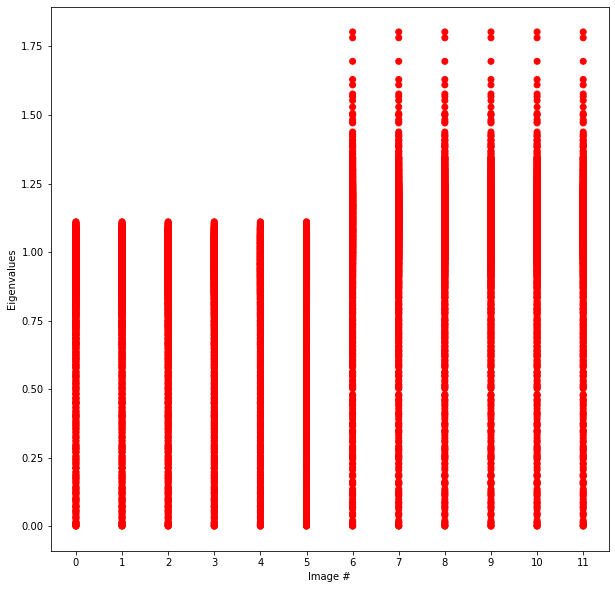

In [82]:
# Plot the range of eigenvalues for a given image
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

# Symmetric laplacian to get only positive eigenvalues... both output cuts but one is correct math

# iterate over each array in the list and create a scatter plot
for i, val in enumerate(vals):
    x = [i] * len(val)
    colors = ['r' if v > 0 else 'g' for v in val]
    ax.scatter(x, val, c=colors)
    # ax.set_ylim(0,0.0005)

# set axis labels and show the plot
plt.xticks(range(len(vals)), range(len(vals)))
plt.xlabel('Image #')
plt.ylabel('Eigenvalues')
plt.show()

In [83]:
if False:
    fig, axs = plt.subplots(len(output_cut), 2, figsize=(6, 30))
    set1 = (x_list,y_list)

    fig.suptitle('Ncut cost and eigenvector spectrum')
    for i in range(len(x_list)):
        # Scatter of ncuts
        axs[i, 0].scatter(x_list[i], y_list[i], color='blue')
        axs[i, 0].set_xlabel('ncut cost')
        axs[i, 0].set_ylabel('eigenvector value')
        axs[i, 0].set_title(f'Ncut cost output[{i}]')
        
        axs[i,0].invert_xaxis()
        axs[i,0].axhline(0, color='black')
        # Scatter of eigenvector
        out = output_cut[i].flatten()
        x = [i] * len(out)
        colors = ['r' if v > 0 else 'g' for v in out]
        axs[i, 1].scatter(x, out, c=colors)
        axs[i, 1].set_title(f'Eigenvector cost output[{i}]')
        axs[i,1].axhline(0, color='black')
    plt.tight_layout()
    plt.show()